# To loan or not to loan - that is the question

This project consists of the development of a data mining case study. It aims to predict whether a loan will be payed back to the bank or not.

## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

## Useful Functions

In [2]:
def csv_df(file, **kwargs):
    return pd.read_csv(file, sep=kwargs.pop('sep', ';'), na_values=kwargs.pop('na_values', None), dtype=kwargs.pop('dtype', None))

def convert_date(df, column, date_format='%y%m%d'):
    copy_df = df.copy()
    copy_df[column] = pd.to_datetime(copy_df[column], format=date_format)

    return copy_df

## Loading Data

In [3]:
account_df = csv_df('../data/account.csv')
client_df = csv_df('../data/client.csv')
disp_df = csv_df('../data/disp.csv')
transaction_df = csv_df('../data/trans_train.csv', dtype={'bank': str})
transaction_test_df = csv_df('../data/trans_test.csv')
loan_df = csv_df('../data/loan_train.csv')
loan_test_df = csv_df('../data/loan_test.csv')
card_df = csv_df('../data/card_train.csv')
card_test_df = csv_df('../data/card_test.csv')
district_df = csv_df('../data/district.csv')

## Domain Description

A Czech bank wants to improve their services using a datamining approach. The bank provides data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued, dating from 1993 to 1998. This data is provided as a set of *.csv* files.

In [4]:
print('Accounts:', account_df['account_id'].nunique())
print('Clients:', client_df['client_id'].nunique())
print('Districts:', district_df['code '].nunique())
print('Transactions:', transaction_df['trans_id'].nunique() + transaction_test_df['trans_id'].nunique())
print('Loans:', loan_df['loan_id'].nunique() + loan_test_df['loan_id'].nunique())

Accounts: 4500
Clients: 5369
Districts: 77
Transactions: 426885
Loans: 682


## Exploratory Data Analysis

Finished loans: 85.98%
Ongoing loans: 14.02%
Correlation between amount and duration * payments:  1.0
Districts with at least 100 clients:
1     663
74    180
70    169
54    155
64    109
72    104


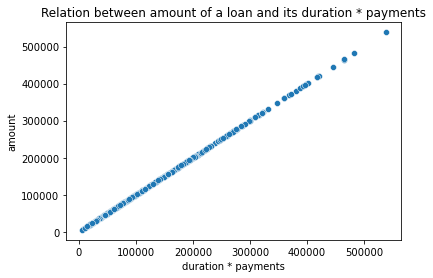

Maximum number of loans on one account: 1


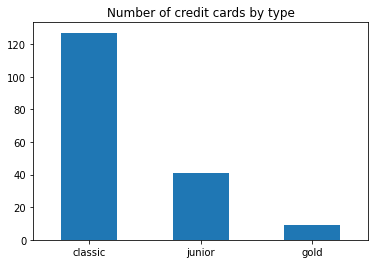

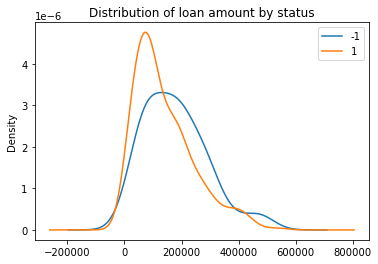

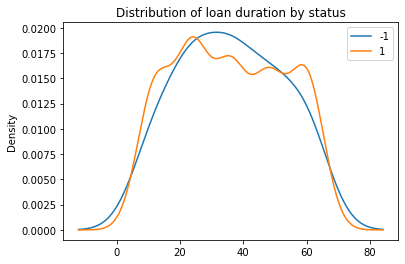

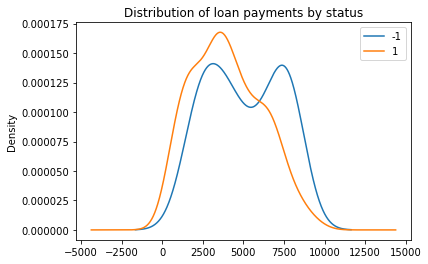

In [5]:
# Most loans have been payed, so 'status' is unbalanced
a, b = loan_df['status'].value_counts()

print('Finished loans: {}%'.format(round(a / (a + b) * 100, 2)))
print('Ongoing loans: {}%'.format(round(b / (a + b) * 100, 2)))

# amount = duration * payments
print('Correlation between amount and duration * payments: ', loan_df['amount'].corr(loan_df['duration'].multiply(loan_df['payments'])))

# Of all the 77 districts, only 6 have at least 100 clients
print('Districts with at least 100 clients:\n{}'.format(
    client_df.groupby('district_id').filter(lambda x: len(x) >= 100)
    ['district_id'].value_counts().to_string()))

# Interest is not visible in the dataset
sb.scatterplot(x=loan_df['duration'].multiply(loan_df['payments']), y=loan_df['amount'], legend='full')
plt.xlabel('duration * payments')
plt.title('Relation between amount of a loan and its duration * payments')
plt.show()

# There's no account with more than one loan
print('Maximum number of loans on one account:', loan_df['account_id'].value_counts().max())

# Most credit cards are classic type
card_df['type'].value_counts().plot(kind='bar', rot=0)
plt.title('Number of credit cards by type')
plt.show()

# Distribution of loan characteristics according to status
loan_df.groupby('status')['amount'].plot(kind='density', legend=True)
plt.title('Distribution of loan amount by status')
plt.show()

loan_df.groupby('status')['duration'].plot(kind='density', legend=True)
plt.title('Distribution of loan duration by status')
plt.show()

loan_df.groupby('status')['payments'].plot(kind='density', legend=True)
plt.title('Distribution of loan payments by status')
plt.show()

# TODO: correlation between gender and loan status
# TODO: distribution of ages when getting a loan
# TODO: distribution of account creation by month
# TODO: distribution of loan status by month

## Data Pre-processing

In [9]:
def preProcessClient(client_df):
    df = client_df.copy()
    
    # Splitting birth_number
    df['year'] = 1900 + (df['birth_number'] // 10000) # get first 2 digits
    df['day'] = df['birth_number'] % 100 # get last 2 digits
    df['mix'] = (df['birth_number'] % 10000) // 100 # get middle digits
    
    # Adding gender column
    df['gender'] = np.where(df['mix'] >= 50, 'F', 'M')
    
    # "Fixing" month, because we already have gender
    df['month'] = np.where(df['mix'] >= 50, df['mix'] - 50, df['mix'])
    
    # Renaming birth_number column to birth
    df['birth_number'] = df['year']*10000 + df['month']*100 + df['day']
    df['birth'] = pd.to_datetime(df['birth_number'], format='%Y%m%d')
    
    # Removing unnecessary columns
    df = df.drop(['birth_number', 'year', 'month', 'day', 'mix'], axis=1)
    
    return df 

def preProcessDisp(disp_df):
    df = disp_df.copy()
    
    return df

def preProcessCard(card_df):
    df = card_df.copy()
    
    df['issued'] = pd.to_datetime(df['issued'], format='%y%m%d')
    
    return df

def preProcessDistrict(district_df):
    df = district_df.copy()
    
    # '?' Values to average: 'no. of commited crimes \'95 '
    crimes_NOTNULL = df['no. of commited crimes \'95 '] != '?'
    crimes_NULL = df['no. of commited crimes \'95 '] == '?'
    crimes_average = pd.to_numeric(df[crimes_NOTNULL]['no. of commited crimes \'95 ']).astype(float).median()
    df.loc[crimes_NULL, 'no. of commited crimes \'95 '] = crimes_average
    
    # '?' Values to average: 'unemploymant rate \'95 '
    unemploymant_NOTNULL = df['unemploymant rate \'95 '] != '?'
    unemploymant_NULL = df['unemploymant rate \'95 '] == '?'
    unemploymant_average = pd.to_numeric(df[unemploymant_NOTNULL]['unemploymant rate \'95 ']).astype(float).median()
    df.loc[unemploymant_NULL, 'unemploymant rate \'95 '] = unemploymant_average
    
    # Int -> Float, Obj -> Numeric
    df['unemploymant rate \'95 '] = df['unemploymant rate \'95 '].astype(float)
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 '] = df['unemploymant rate \'96 '].astype(float)
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])
    df['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(df['no. of enterpreneurs per 1000 inhabitants '])
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '].astype(float)
    
    # Ratio: 0-1
    df['entrepeneurs ratio'] = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '] / 100
    
    # 95-96 Increase on Crimes and Unemploymant
    df['crimes_increase'] = (df['no. of commited crimes \'96 '] - df['no. of commited crimes \'95 ']) / df['no. of inhabitants']
    df['unemploymant_increase'] = df['unemploymant rate \'96 '] - df['unemploymant rate \'95 ']

    # Removing unnecessary columns
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants ', 
                 'unemploymant rate \'96 ', 'no. of commited crimes \'96 ',
                  'unemploymant rate \'95 ', 'no. of commited crimes \'95 ', 'name '], axis=1)        
    
    df = df.rename(columns={'code ': 'district_id'})
    print(df.info())
    print(df.describe())
    return df

def preProcessAccount(account_df):
    df = account_df.copy()
    
    # Splitting account creation date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Removing unnecessary columns
    df = df.drop(['date', 'day', 'frequency'], axis=1)
    
    return df
    
def preProcessLoan(loan_df):
    df = loan_df.copy()
    
    # Splitting loan grant date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Removing unnecessary columns
    df = df.drop(['date', 'day'], axis=1)
    
    return df
    
def preProcessTransaction(transaction_df):
    df = transaction_df.copy()
    
    # Splitting loan grant date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Replacing values in type column
    df['type'].replace({'credit': 1, 'withdrawal': -1}, inplace=True)
    
    # Removing unnecessary columns
    df = df.drop(['date', 'day', 'bank', 'account', 'operation', 'balance', 'k_symbol'], axis=1)
    
    return df
    
a = preProcessTransaction(transaction_df)
print(a.head())

   trans_id  account_id type   amount  year  month
0   1548749        5270    1    800.0  1993      1
1   1548750        5270    1  44749.0  1993      1
2   3393738       11265    1   1000.0  1993      1
3   3122924       10364    1   1100.0  1993      1
4   1121963        3834    1    700.0  1993      1
